In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import plotly.express as px

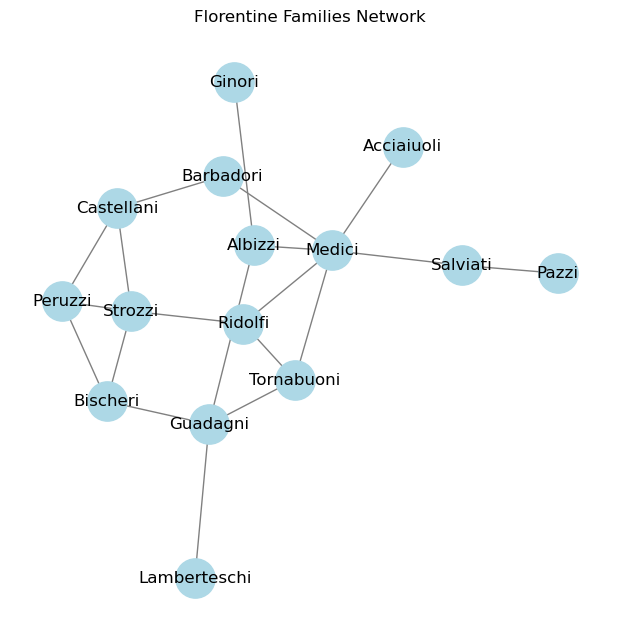

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

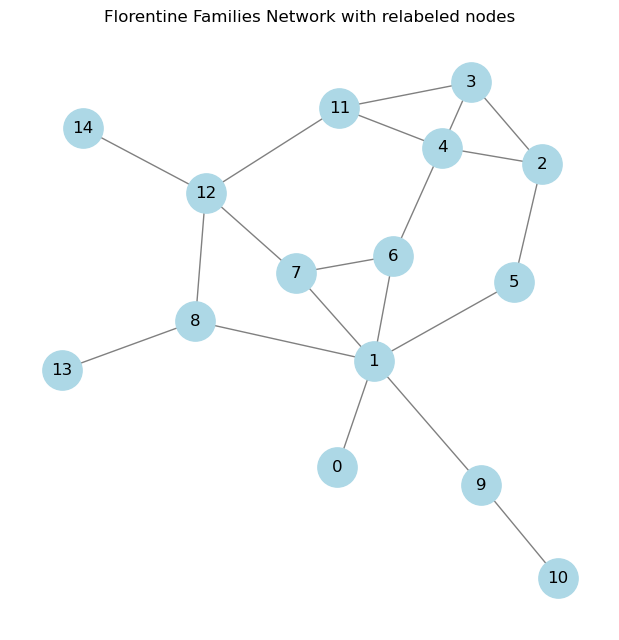

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [3]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

[]

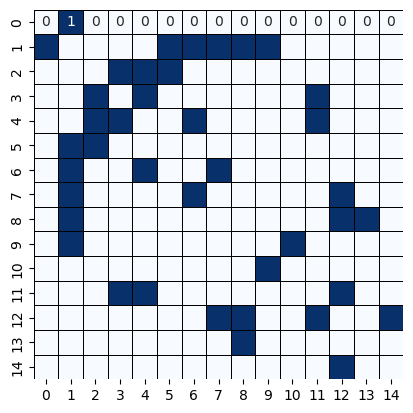

In [4]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=True, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')
plt.plot()

# Latent space

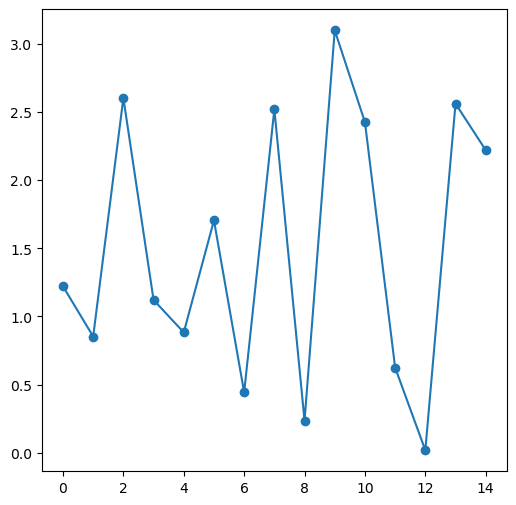

In [5]:
n = len(G.nodes)

angles_init_r = np.pi*np.random.rand(n)


plt.figure(figsize=(6,6))
plt.plot(range(n),angles_init_r, 'o-')
plt.show()

# Likelihood

-139.91335806249197
-138.60645311239887


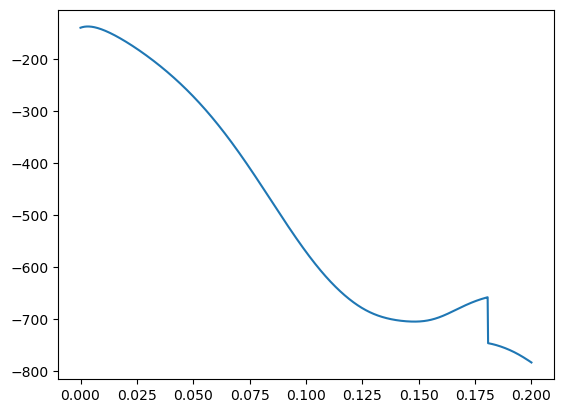

In [6]:
def loglikelihood(angles,alpha):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            d =  (angles[i] - angles[j])**2 
            eta = alpha * (1 - d)
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

def grad_loglikelihood(angles,alpha):
    grad_angles = np.zeros_like(angles)
    grad_alpha = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist =  (angles[i] - angles[j])**2 
                eta = alpha * ( 1 - dist )
                grad_angles[i] +=  ((y-expit(eta)) * 2 * (angles[i] - angles[j])).item()
                grad_alpha += (y-expit(eta)) * (1 - dist) 
    return grad_angles, grad_alpha

def update_angles(angles, grad_angles):
    return np.mod(angles + grad_angles, np.pi)

grad_angles,  grad_alpha = grad_loglikelihood(angles_init_r,0.1)
lr = 0.001
print(loglikelihood(angles_init_r,0.1))
print(loglikelihood(update_angles(angles_init_r, lr*grad_angles),0.1+lr*grad_alpha))
plt.plot(np.linspace(0.0,0.2,1000),[loglikelihood(update_angles(angles_init_r, lr*grad_angles),0.1+lr*grad_alpha) for lr in np.linspace(0.0,0.2,1000)])
plt.show()

## Searching MLE

Log likelihood of MLE -80.00979794134683


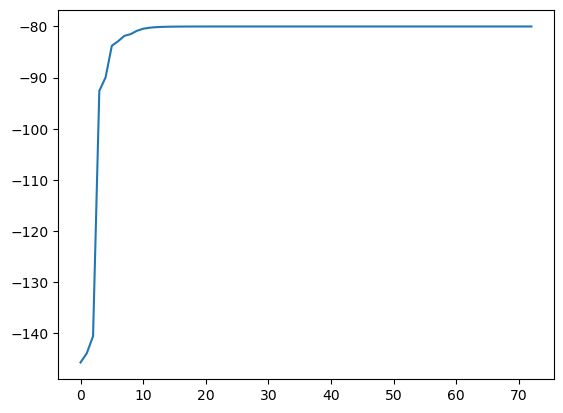

In [7]:
def SearchingMLE(angles_init, alpha_init, tol=1e-4, max_iter=2000, a_init=0.5, rho=0.5, c=1e-4):
    angles0 = angles_init
    historyangles = [angles0]

    alpha0 = alpha_init
    historyalpha = [alpha0]
    
    for i in range(max_iter):
        grad_angles,  grad_alpha = grad_loglikelihood(angles0,alpha0)
        if np.linalg.norm(grad_angles) + np.abs(grad_alpha) < tol:
            break  # Convergence criterion
        if i == max_iter-1:
            print("Máximo número de iteraciones alcanzada")
        
        a= a_init
        
        # Line search using the Armijo condition
        while loglikelihood(update_angles(angles0, a*grad_angles) ,alpha0 + a*grad_alpha) < loglikelihood(angles0,alpha0)+ c * a * ( np.transpose(grad_angles) @ angles0 + grad_alpha * alpha0):
            a *= rho
            if a < 1e-4:
                a = 0.0
                break
        
        # Update step
        angles0 = update_angles(angles0, a*grad_angles) 
        alpha0 = alpha0 + a * grad_alpha
        
        historyangles.append(angles0)
        historyalpha.append(alpha0)
    
    return  angles0, alpha0, historyangles, historyalpha


angles_ML, alpha_ML, historyangles, historyalpha  =  SearchingMLE(np.pi*np.random.rand(n) ,np.random.randn())
print("Log likelihood of MLE", loglikelihood(angles_ML, alpha_ML))
plt.plot([loglikelihood(historyangles[t],historyalpha[t]) for t in range(len(historyalpha))])
plt.show()

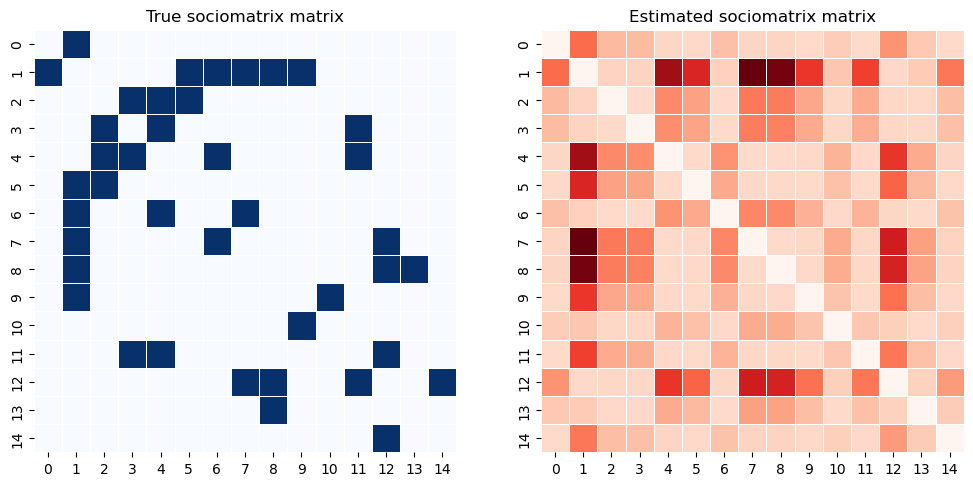

In [8]:
Y_MLE = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d =  0.5 * (angles_ML[i] - angles_ML[j])**2 
            Y_MLE[i,j] = expit(alpha_ML * (1 - d))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_MLE, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

# Prior distribution

-15.319864180977625
-15.491122003668124


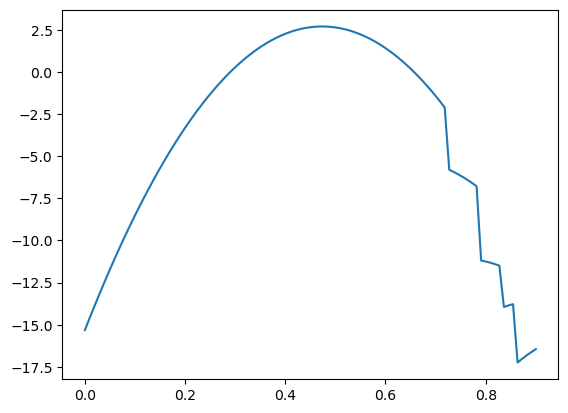

In [9]:
def logpriori(angles,alpha,var=0.1):
    logpriorangles = 0.0
    for i in range(len(angles)):
        logpriorangles += 0.01*angles[i] if (0.0 <= angles[i] <= np.pi) else -1E2
        logpriorangles +=  (angles_ML[i] - angles[i])**2
    logprioralpha = 0.5 * alpha**2 / var
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + logpriorangles + logprioralpha)


def grad_logpriori(angles,alpha,var=0.1):
    grad_angles = np.zeros_like(angles)
    for i in G.nodes():
        grad_angles[i] += 0.1 if (0.0 <= angles[i] <= np.pi) else 0.0
        grad_angles[i] += 2 * (angles_ML[i] - angles[i])
    grad_alpha = (-1) * alpha / var  
    return grad_angles, grad_alpha

grad_angles,  grad_alpha = grad_logpriori(angles_init_r,0.1)
lr = 1.0
print(logpriori(angles_init_r,0.1))
print(logpriori(update_angles(angles_init_r, lr*grad_angles),0.1+lr*grad_alpha))
plt.plot(np.linspace(0.0,0.9,100),[logpriori(update_angles(angles_init_r, lr*grad_angles),0.1+lr*grad_alpha) for lr in np.linspace(0.0,0.9,100)])
plt.show()

# Potential Energy

173.60890298742197
368.7832691384777


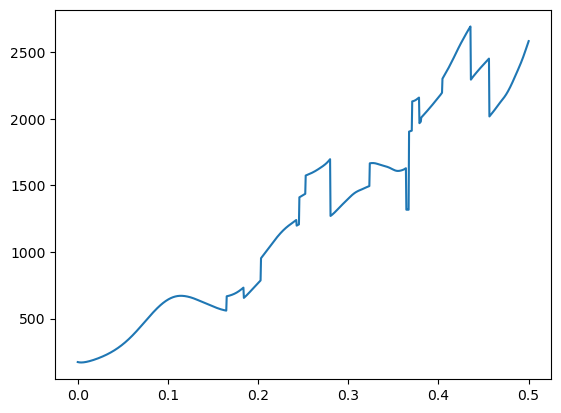

In [10]:
def U(angles,alpha,var=1):
    return (-1) * (loglikelihood(angles,alpha) + logpriori(angles,alpha,var))

def grad_U(angles,alpha,var=1):
    grad_angles_likelihood, grad_alpha_likelihood = grad_loglikelihood(angles,alpha)
    grad_angles_priori, grad_alpha_priori = grad_logpriori(angles,alpha,var)
    grad_angles = grad_angles_likelihood + grad_angles_priori
    grad_alpha = grad_alpha_likelihood + grad_alpha_priori
    return -grad_angles, -grad_alpha

grad_angles,  grad_alpha = grad_U(angles_init_r,0.1)
lr = 0.06
print(U(angles_init_r,0.1))
print(U(update_angles(angles_init_r, -lr*grad_angles),0.1 - lr*grad_alpha))
plt.plot(np.linspace(0.0,0.5,1000),[U(update_angles(angles_init_r, -lr*grad_angles),0.1-lr*grad_alpha) for lr in np.linspace(0.0,0.5,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [11]:
def compute_star(Old, Ref):
    New = Old + np.mean(Ref-Old)
    return New 

def hmc(angles_init, alpha_init, num_samples, epsilon_init=0.05, std_dev_init=1.0, warmup=100):
    samples_angles = [angles_init]
    samples_alpha = [alpha_init]
    Hamiltonian_p = [U(angles_init,alpha_init)]
    LogL = [loglikelihood(angles_init,alpha_init)]

    # Parámetros adaptativos
    epsilon = epsilon_init
    std_dev = std_dev_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    acep_rate_history = np.zeros(num_samples)
    
    for iter in tqdm(range(num_samples)):
        # Adaptación de parámetros
        adapting = iter < warmup
        if adapting and iter > 0 and iter % 2 == 0:
            # Ajustar epsilon basado en tasa de aceptación reciente
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.80:
                epsilon = np.max(np.array([0.01,0.99*epsilon])) 
                std_dev = np.max(np.array([0.05,0.99*std_dev]))
            elif current_accept_rate > 0.60:
                epsilon = np.min(np.array([0.2,1.01*epsilon]))
                std_dev = np.min(np.array([0.75,1.01*std_dev]))
            L = max(1, int(round(1/epsilon)))  # Actualizar L
        elif iter == warmup:
            print(f"Final parameters: epsilon={epsilon:.4f}, L={L}, std_dev={std_dev:.4f}")

        angles = samples_angles[-1].copy()
        alpha = samples_alpha[-1].copy()


        for i in range(n):
            p_i = np.random.normal(0, std_dev, size=1)
            current_p = p_i.copy()

            #Leapfrog integration
            grad_angles,  _ = grad_U(angles,samples_alpha[-1])
            grad_angles_i = grad_angles[i]
            p_i -= epsilon * grad_angles_i / 2       
            for l in range(L):
                angles[i] = np.mod(angles[i] + epsilon*p_i, np.pi)[0]
            grad_angles,  _ = grad_U(angles,samples_alpha[-1])
            p_i -= epsilon * grad_angles_i / 2
   

            # Hamiltonian
            current_U = U(samples_angles[-1],samples_alpha[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(angles,samples_alpha[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H
            if log_accept_ratio > 0:
                samples_alpha.append(samples_alpha[-1])
                samples_angles.append(angles)
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
                LogL.append(loglikelihood(angles,samples_alpha[-1]))
            elif np.random.rand() < np.exp(log_accept_ratio):
                samples_alpha.append(samples_alpha[-1])
                samples_angles.append(angles.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
                LogL.append(loglikelihood(angles,samples_alpha[-1]))
            else:
                samples_alpha.append(samples_alpha[-1])
                samples_angles.append(samples_angles[-1])
                Hamiltonian_p.append(current_H)
                LogL.append(LogL[-1])
            total_updates += 1   

            grad_angles,  grad_alpha = grad_U(samples_angles[-1],samples_alpha[-1])

        

        ### HMC algorithm for alpha
        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_alpha / 2        
        for l in range(L):
            alpha += epsilon * p
            _,  grad_alpha = grad_U(samples_angles[-1],alpha)
            p -= epsilon * grad_alpha
        p -= epsilon * grad_alpha / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_angles[-1],samples_alpha[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_angles[-1],alpha)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if log_accept_ratio > 0:
            samples_alpha.append(alpha.copy())
            samples_angles.append(samples_angles[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
            LogL.append(loglikelihood(samples_angles[-1],alpha))
        elif np.random.rand() < np.exp(log_accept_ratio):
            samples_alpha.append(alpha.copy())
            samples_angles.append(samples_angles[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
            LogL.append(loglikelihood(samples_angles[-1],alpha))
        else:
            samples_alpha.append(samples_alpha[-1])
            samples_angles.append(samples_angles[-1])
            Hamiltonian_p.append(current_H)
            LogL.append(LogL[-1])
        total_updates += 1    
        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0
    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    
    samples_angles = np.array(samples_angles)
    samples_alpha = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_alpha]
    Hamiltonian_p = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p]
    LogL = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in LogL]
    return samples_angles, samples_alpha, Hamiltonian_p, LogL, acep_rate_history

In [12]:
angles1 = np.pi*np.random.rand(n)
alpha1 = np.float64(0.0 + np.random.randn())

print("Log-L MLE:", loglikelihood(angles_ML,alpha_ML))
print("Log-L starter:", loglikelihood(angles1,alpha1))

Log-L MLE: -80.00979794134683
Log-L starter: -182.5861743462533


In [13]:
# Execute HMC
number_of_iterations = 1000
number_warmup = int(number_of_iterations * 0.20)
number_of_samples = number_of_iterations*(n+1) + 1
samples_angles, samples_alpha, Hp, LogLp, acep_rate_history = hmc(angles1, alpha1, number_of_iterations, epsilon_init=0.5, std_dev_init=0.1, warmup=number_warmup)
samples_angles = [compute_star(samples_angles[i],angles_ML) for i in range(len(samples_angles))]
samples_angles = np.array(samples_angles)
# Estimators
## CM
angles_CM =  np.mean(samples_angles, axis=0)          
alpha_CM = np.mean(samples_alpha, axis=0)
## MAP
angles_MAP = samples_angles[np.argmin(Hp),:]
alpha_MAP = samples_alpha[np.argmin(Hp)]

print("Log-L MLE:", loglikelihood(angles_ML,alpha_ML))
print("Log-L MAP:", loglikelihood(angles_MAP,alpha_MAP))
print("Log-L CM:", loglikelihood(angles_CM,alpha_CM))
print("Log-L starter:", loglikelihood(angles1,alpha1))

 20%|██        | 201/1000 [00:48<04:04,  3.27it/s]

Final parameters: epsilon=0.1849, L=5, std_dev=0.0500


100%|██████████| 1000/1000 [26:06<00:00,  1.57s/it]   

Acceptance rate: 0.86906
Log-L MLE: -80.00979794134683
Log-L MAP: -80.89619476514777
Log-L CM: -83.1096676027365
Log-L starter: -182.5861743462533


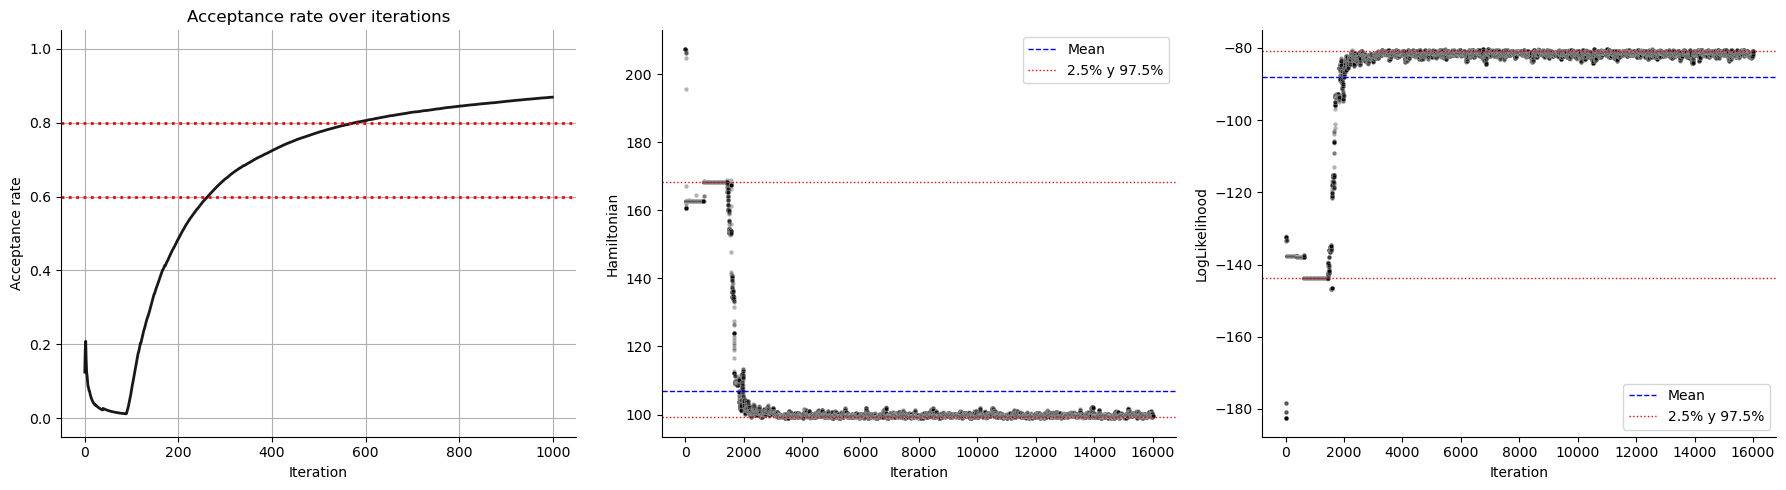

In [14]:
x1 = Hp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({'Iteration': iterations1, 'Values': x1})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

x2 = LogLp
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({'Iteration': iterations2, 'Values': x2})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

# Crear figura 1x3
fig, axs = plt.subplots(1, 3, figsize=(18, 5)) 

# Subplot 1: Acceptance rate
axs[0].plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
axs[0].axhline(0.80, color='red', linestyle=':', linewidth=2)
axs[0].axhline(0.60, color='red', linestyle=':', linewidth=2)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Acceptance rate")
axs[0].set_title("Acceptance rate over iterations")
axs[0].set_ylim(-0.05, 1.05)
axs[0].grid(True)

# Subplot 2: Hamiltonian
sns.scatterplot(ax=axs[1], x='Iteration', y='Values', data=data1, color='black', alpha=0.3, s=10)
axs[1].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("Hamiltonian")
axs[1].legend()

# Subplot 3: LogLikelihood
sns.scatterplot(ax=axs[2], x='Iteration', y='Values', data=data2, color='black', alpha=0.3, s=10)
axs[2].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[2].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[2].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[2].set_xlabel("Iteration")
axs[2].set_ylabel("LogLikelihood")
axs[2].legend()

sns.despine()
plt.tight_layout()
plt.show()


In [15]:
samples_angles[:,10].shape

(16001,)

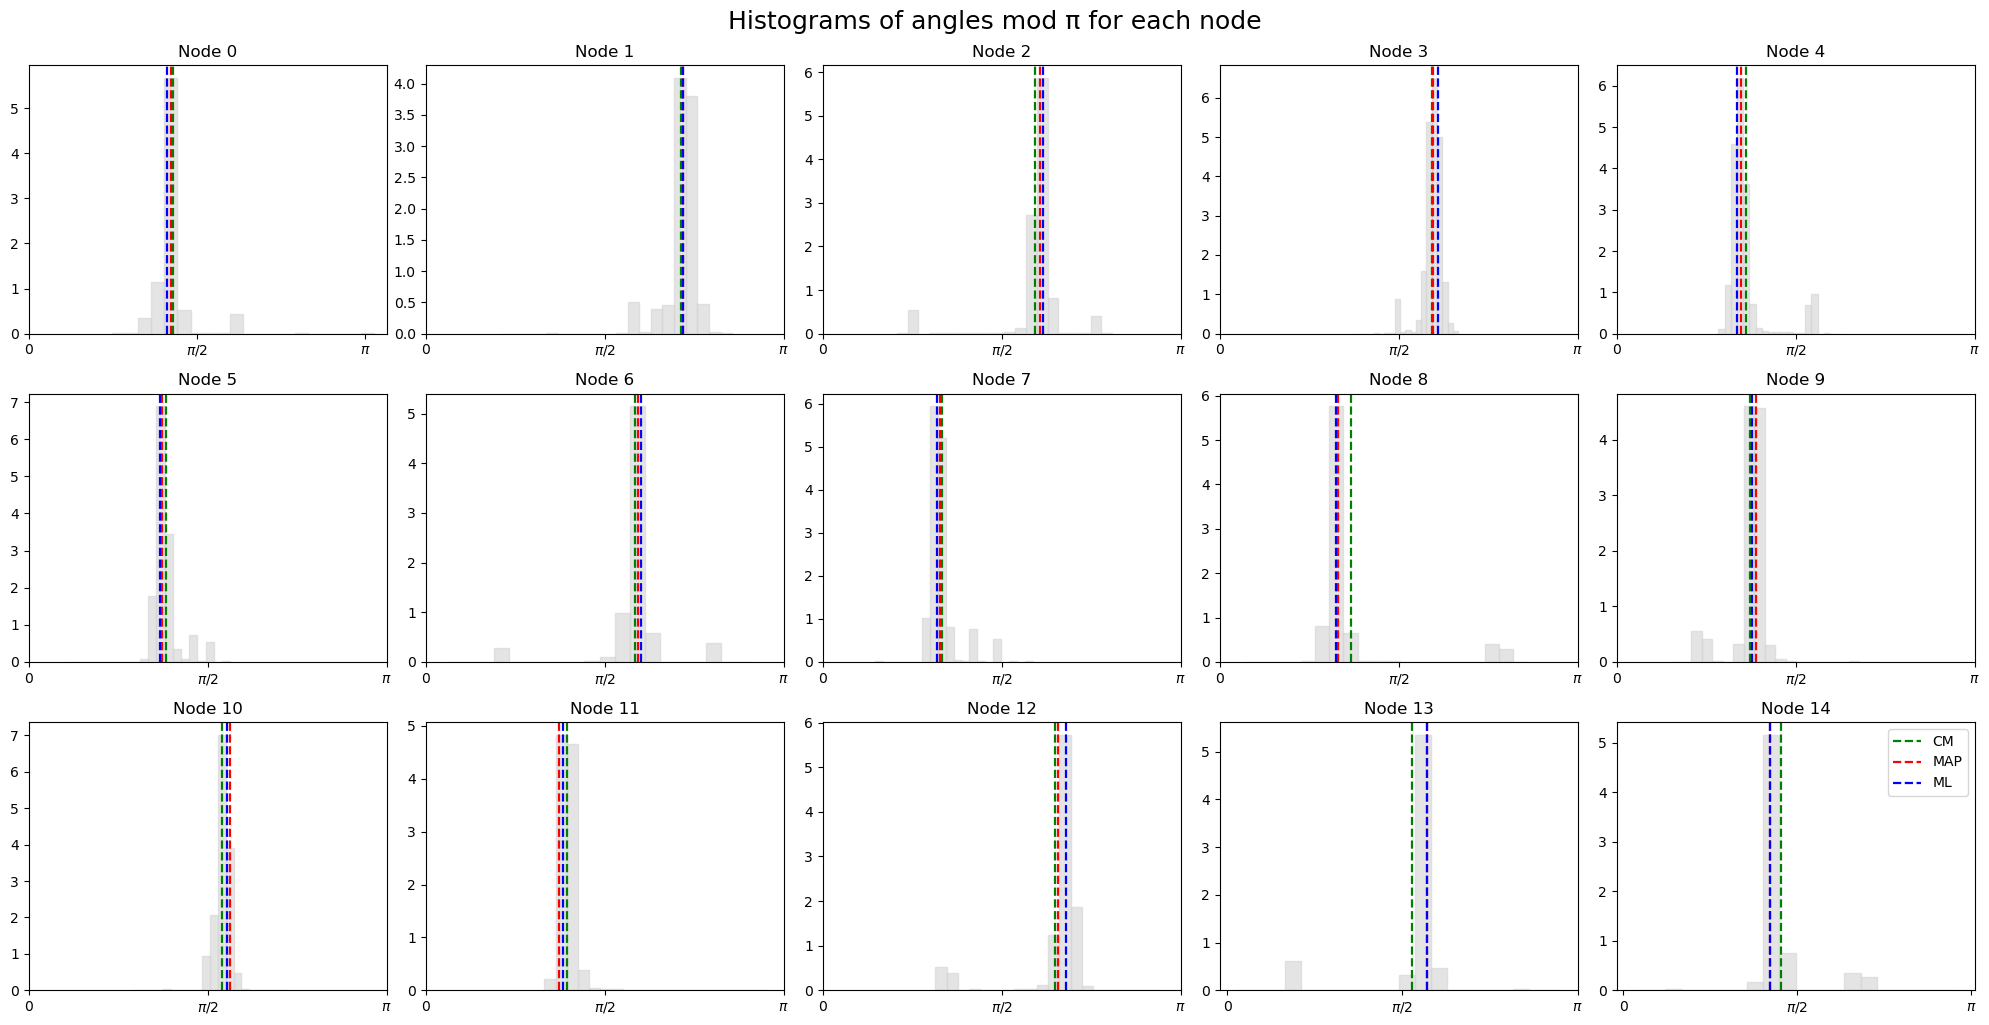

In [16]:
fig, axes = plt.subplots(3, 5, figsize=(20, 10))  # 3 filas x 5 columnas
axes = axes.flatten() 

for i in range(n):
    ax = axes[i]
    ax.hist(samples_angles[:,i], bins=20, color='lightgray', edgecolor='lightgray', alpha=0.6, density=True)
    ax.axvline(angles_CM[i], color='green', linestyle='dashed', linewidth=1.6)
    ax.axvline(angles_MAP[i], color='red', linestyle='dashed', linewidth=1.6)
    ax.axvline(angles_ML[i], color='blue', linestyle='dashed', linewidth=1.6)
    ax.set_title(f'Node {i}')
    ax.set_xticks([0, np.pi/2, np.pi ])
    ax.set_xticklabels(['0', r'$\pi/2$', r'$\pi$'])
    ax.grid(False)
plt.legend(['CM','MAP','ML'], loc='upper right')
plt.tight_layout()
plt.suptitle("Histograms of angles mod π for each node", y=1.02, fontsize=18) 
plt.show()

c:\Users\carlo\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


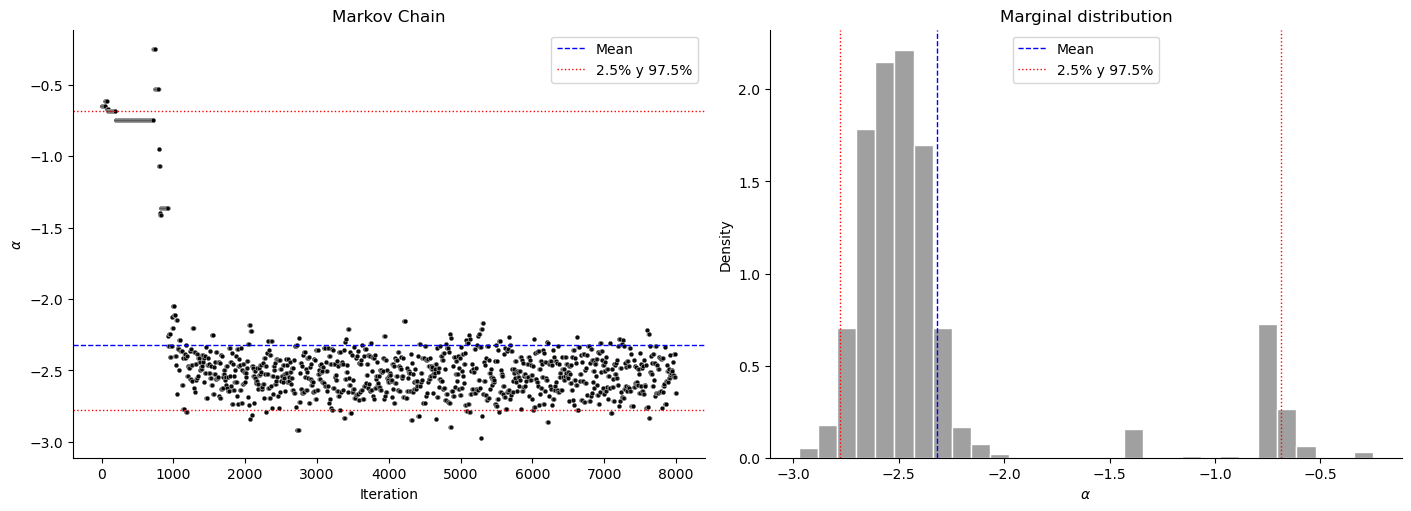

In [17]:
#
x = samples_alpha[1:-1:2]
#
iterations = np.arange(1, len(x) + 1)

mean_x = np.mean(x)
quantiles_x = np.quantile(x, [0.025, 0.975])

fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

sns.scatterplot(x=iterations, y=x, color='black', alpha=0.3, s=10, ax=axes[0])
axes[0].axhline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[0].axhline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[0].axhline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[0].set_xlabel("Iteration")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title("Markov Chain")
axes[0].legend()
sns.despine(ax=axes[0])

sns.histplot(x, bins=30, kde=False, stat='density', color='gray', edgecolor='white', ax=axes[1])
axes[1].axvline(mean_x, color='blue', linestyle='--', linewidth=1, label='Mean')
axes[1].axvline(quantiles_x[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axes[1].axvline(quantiles_x[1], color='red', linestyle=':', linewidth=1)
axes[1].set_xlabel(r"$\alpha$")
axes[1].set_ylabel("Density")
axes[1].set_title("Marginal distribution")
axes[1].legend()
sns.despine(ax=axes[1])

plt.show()